# Imports

In [15]:
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from scipy.io import loadmat
from glob import glob
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
from keras.optimizers import Adadelta
from keras.utils import multi_gpu_model
from os.path import join, basename, isdir

sys.path.append('scripts')
from data_helpers import *
from model_helpers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
OUT_PATH_MODEL = 'saved'

# Hyperparameters

In [4]:
# Data hyperparameters
ratio_0_1 = 1
excluded_classes = [1, 2, 3]
target_size = (224, 224)
test_ratio = 0.25

# Model hyperparameters
mobilenet_width = 1
dense_layers = [128, 64, 32]

# Train hyperparameters
num_epochs = 500
batch_size = 8

# Load data

In [14]:
files = sorted(glob('data/imgs/*jpg'))
classes = loadmat('data/imagelabels.mat')['labels'][0].tolist()

unique_labels = set(classes)
grouped_files = [[(data[0], data[1]) for data in zip(files, classes) if data[1] == label]
                 for label in unique_labels if label not in excluded_classes]

same_pairs, diff_pairs, rest_data = create_pairs(grouped_files, ratio_0_1=ratio_0_1)

print('Number of same pairs: {} - Number of different pairs: {}'.format(len(same_pairs), len(diff_pairs)))

Number of same pairs: 1974 - Number of different pairs: 2050


## Create metadata for tensorboard embedding

In [17]:
pairs = same_pairs + diff_pairs
file_pairs = [(pair[0][0], pair[1][0]) for pair in pairs]
class_pairs = [(pair[0][1], pair[1][1]) for pair in pairs]
labels = [int(not (pair[0] == pair[1])) for pair in class_pairs]

In [18]:
train_files, test_files, c_train, c_test, y_train, y_test = train_test_split(
        file_pairs, class_pairs, labels, test_size=test_ratio, shuffle=True, stratify=labels)

In [19]:
train_files, test_files, c_train, c_test, y_train, y_test = train_files[:100], test_files[:100], c_train[:100], c_test[:100], y_train[:100], y_test[:100]

In [20]:
x_train = create_img_pairs(train_files, 'train', target_size=target_size)
print('Loaded train data!')
x_test = create_img_pairs(test_files, 'test', target_size=target_size)
print('Loaded test data!')

Loaded train data!
Loaded test data!


In [56]:
vis_files = [pair[0] for pair in test_files] + [pair[1] for pair in test_files]
vis_imgs = np.array([pair[0] for pair in x_test] + [pair[1] for pair in x_test])
vis_classes = [pair[0] for pair in c_test] + [pair[1] for pair in c_test]

In [47]:
if not isdir('saved/logs'):
    os.makedirs('saved/logs')

with open('saved/logs/metadata.tsv', 'w') as f:
    f.write('Filename\tFlower Class\n')
    for file, flower_class in zip(vis_files, vis_classes):
        f.write('{}\t{}\n'.format(basename(file), flower_class))

('data/imgs/image_00615.jpg', 'data/imgs/image_00721.jpg')


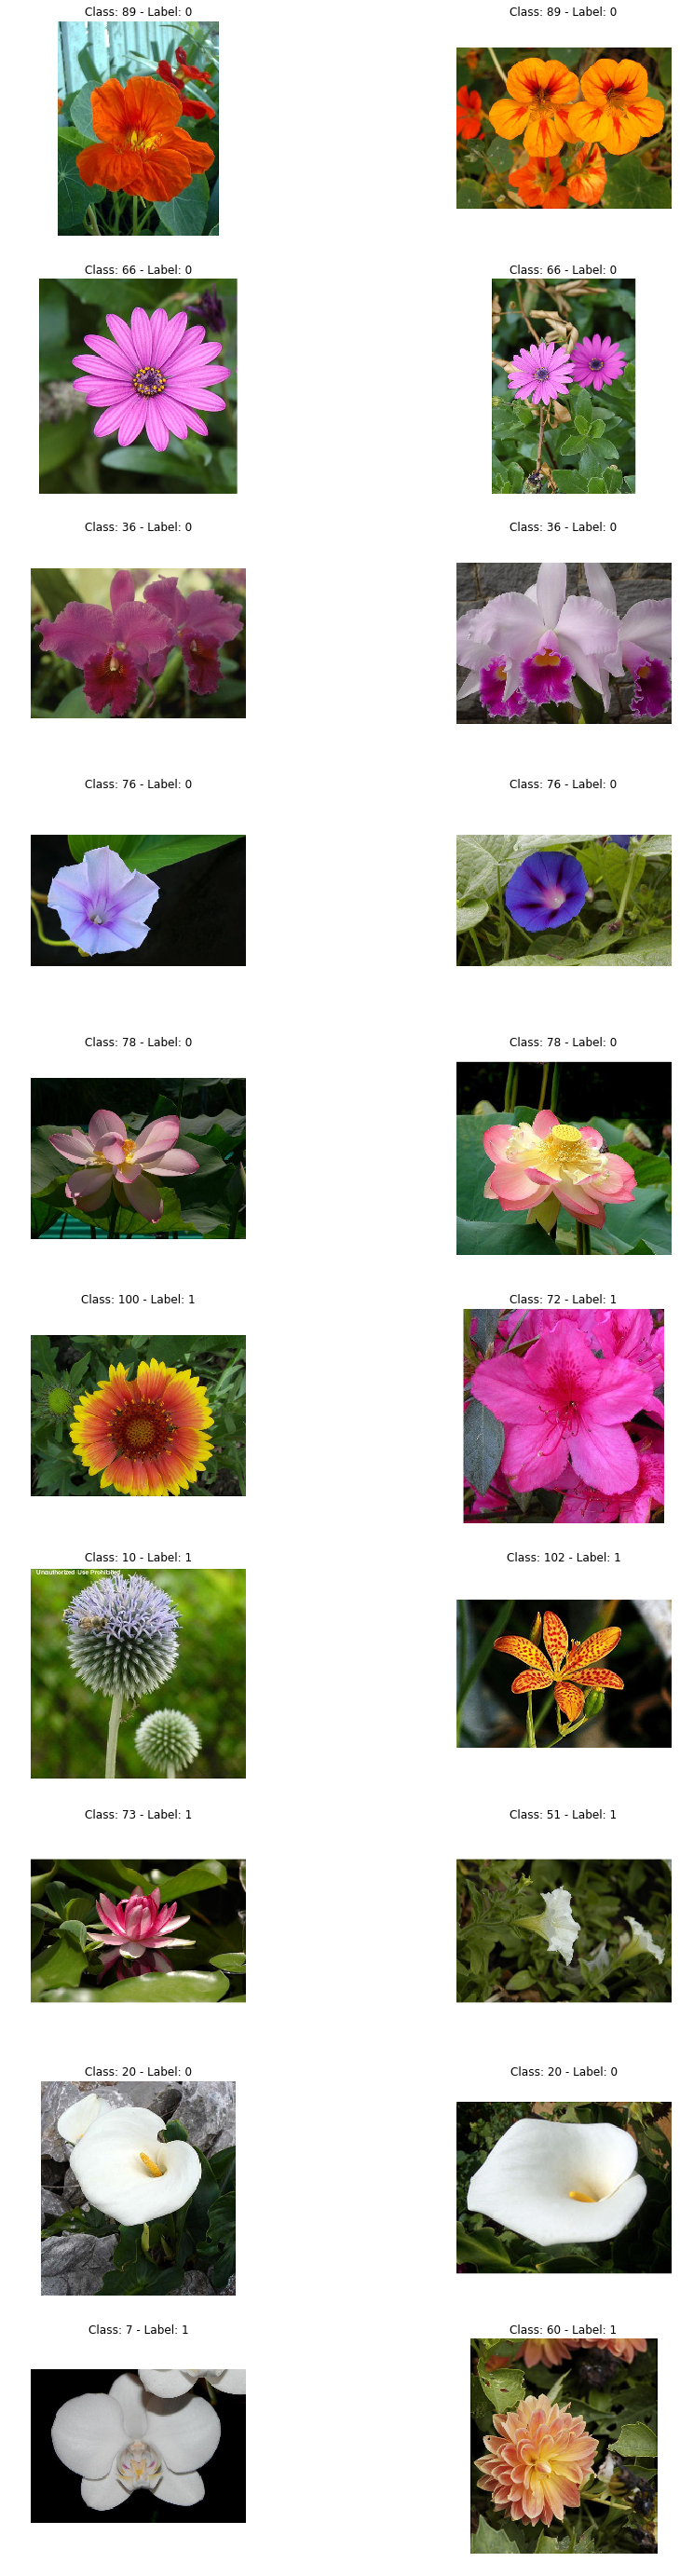

In [48]:
num_vis = 10
fig, ax = plt.subplots(nrows=num_vis, ncols=2, figsize=(15, 50))
for row in range(num_vis):
    for col in range(2):
        ax[row][col].set_title('Class: {} - Label: {}'.format(c_train[row][col], y_train[row]))
        ax[row][col].imshow(x_train[row][col])
        ax[row][col].axis('off')


In [49]:
training_generator = DataGenerator(
    x_train,
    y_train, 
    batch_size=batch_size, 
    augment=True,
    shuffle=True)

# Create and compile models

In [23]:
# Create models
encoder = create_mobile_net_encoder((*target_size, 3), dense_layers, mobilenet_width=mobilenet_width)
siamese_model = create_siamese_model(encoder, distance_func=euclidean_distance)
siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
first_input (InputLayer)        (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
second_input (InputLayer)       (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32)           2432288     first_input[0][0]                
                                                                 second_input[0][0]               
__________________________________________________________________________________________________
distance (Lambda)               (None, 1)            0           model_1[1][0]                    
          

In [24]:
# Compile siamese model
siamese_model.compile(loss=contrastive_loss, optimizer=Adadelta(), metrics=[siamese_accuracy])

## Save hyperparameters in model

In [25]:
siamese_model.train_files = train_files 
siamese_model.test_files = test_files
siamese_model.c_train = c_train
siamese_model.c_test = c_test
siamese_model.y_train = y_train
siamese_model.y_test = y_test
siamese_model.ratio_0_1 = ratio_0_1
siamese_model.excluded_classes = excluded_classes
siamese_model.target_size = target_size
siamese_model.test_ratio = test_ratio
siamese_model.mobilenet_width = mobilenet_width
siamese_model.dense_layers = dense_layers
siamese_model.num_epochs = num_epochs
siamese_model.batch_size = batch_size

# Create callbacks

In [57]:
# checkpointer = CustomModelCheckpoint(
#     join(OUT_PATH_MODEL, 'logs'), 
#     monitor='val_loss', 
#     verbose=0, 
#     save_weights_only=False, 
#     mode='auto', 
#     period=1)

tensorboard = CustomTensorBoard(
    log_dir=join(OUT_PATH_MODEL, 'logs'),
    batch_size=batch_size, 
    encoder=encoder,
    embeddings_freq=1,
    metadata_path='metadata.tsv', 
    embeddings_data=vis_imgs)

In [60]:
test = [(f, img) for f, img in zip(vis_files, vis_imgs) if f in ['image_05812.jpg', 'image_01209.jpg', 'image_07955.jpg']]


In [ ]:
vis_files

# Train model

In [58]:
# Start training
siamese_model.fit_generator(
    generator=training_generator,
    validation_data=(split_imgs(np.array(x_test)), y_test),
    epochs=num_epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=True,
    workers=10,
    callbacks=[tensorboard])

keys ['dense_3']
Epoch 1/500
12/12 [==============================] - 6s 506ms/step - loss: 0.1817 - siamese_accuracy: 0.4792 - val_loss: 0.1183 - val_siamese_accuracy: 0.6500
Epoch 2/500
12/12 [==============================] - 3s 229ms/step - loss: 0.1764 - siamese_accuracy: 0.4688 - val_loss: 0.1588 - val_siamese_accuracy: 0.6100
Epoch 3/500
12/12 [==============================] - 3s 221ms/step - loss: 0.1464 - siamese_accuracy: 0.5521 - val_loss: 0.1753 - val_siamese_accuracy: 0.6100
Epoch 4/500
12/12 [==============================] - 3s 239ms/step - loss: 0.1420 - siamese_accuracy: 0.5625 - val_loss: 0.1125 - val_siamese_accuracy: 0.6800
Epoch 5/500
12/12 [==============================] - 3s 215ms/step - loss: 0.1463 - siamese_accuracy: 0.6146 - val_loss: 0.1532 - val_siamese_accuracy: 0.6100


Process ForkPoolWorker-117:
Process ForkPoolWorker-120:
Process ForkPoolWorker-118:
Process ForkPoolWorker-111:
Process ForkPoolWorker-116:
Process ForkPoolWorker-115:
Process ForkPoolWorker-114:
Process ForkPoolWorker-119:
Process ForkPoolWorker-112:
Process ForkPoolWorker-113:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/q450586/.conda/envs/my-env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/q450586/.conda/envs/my-env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/q450586/.conda/envs/my-env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (mo

KeyboardInterrupt: 